In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt
from sklearn import tree
#import pydotplus
import collections
from IPython.display import Image  
#import pydotplus
from sklearn.tree import export_graphviz
import random

In [2]:
import copy

In [3]:
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

#from sklearn.ensemble import RandomForestClassfier
from sklearn.feature_selection import SelectFromModel

In [87]:
df = pd.read_stata("Econ_484_data_final.dta")
df_1 = pd.read_stata("Econ_484_data_final.dta")

In [88]:
df = df.drop("DAYSWAIT_CHRON", axis=1)

In [89]:
df = df.dropna(axis=0, how='any')


In [90]:
df['year'] = pd.DatetimeIndex(df["TX_DATE"]).year
df['month'] = pd.DatetimeIndex(df["TX_DATE"]).month
df = df.drop("TX_DATE", axis=1)
df_1 = df

### Here I sort the dataframe by the Wait List length and put people into quintile buckets 0-4, 0 being the shortest quintile waitlist time and 4 being the longest wl time. I also create an ID indictator so I can identify people later on. 

In [91]:
 df['quint']=df.groupby('PERM_STATE')['DAYSWAIT_CHRON_KI'].transform(pd.qcut,5,labels=False)

In [92]:
df['id'] = df.index
df.set_index('id', inplace=True)


### Now I am creating lists of the of the ID values for each quintile and then creating a list of 25 random people from our quintile sample. I can drop the quint column after I am done with this. 

In [93]:
rand_people_0_wl = df.query('quint == 0').index.tolist() 
sampling_0 = random.sample(rand_people_0_wl, k=25)
rand_people_1_wl = df.query('quint == 1').index.tolist()
sampling_1 = random.sample(rand_people_1_wl, k=25)
rand_people_2_wl = df.query('quint == 2').index.tolist()
sampling_2 = random.sample(rand_people_2_wl, k=25)
rand_people_3_wl = df.query('quint == 3').index.tolist()
sampling_3 = random.sample(rand_people_3_wl, k=25)
rand_people_4_wl = df.query('quint == 4').index.tolist()
sampling_4 = random.sample(rand_people_4_wl, k=25)

In [94]:
df = df.drop('quint', axis=1)

### These are the "Average" People Logan Created, I am adding them into the bottom of the data frame

In [95]:
df_ave = pd.read_excel('data_5.xlsx', sheet_name= 'Sheet2')
df_ave

,NUM_PREV_TX,A1,A2,B1,B2,DR1,DR2,gender,abo,PERM_STATE,...,PX_STAT,SHARE_TY,pstatus,ptime,AGE_GROUP,malig,LT_ONE_WEEK_DON,RECOV_OUT_US,year,month
0,0,2,24,27,49,4,11,M,A,CA,...,A,3,0,2031,A,N,N,N,2006,7
1,0,2,24,35,50,7,11,M,O,CA,...,A,3,0,2177,A,N,N,N,2006,7
2,0,2,28,35,51,7,12,M,O,CA,...,A,3,0,1677,A,N,N,N,2010,7


In [96]:
frames=[df, df_ave]
df = pd.concat(frames).reset_index(drop=True)

In [97]:
# Average People are included
df_1=df
df.tail()


,NUM_PREV_TX,A1,A2,B1,B2,DR1,DR2,gender,abo,PERM_STATE,...,PX_STAT,SHARE_TY,pstatus,ptime,AGE_GROUP,malig,LT_ONE_WEEK_DON,RECOV_OUT_US,year,month
401746,0,36,68,53,57,11,13,M,O,IL,...,A,3,0,3.0,A,N,N,,2018,12
401747,1,2,2,55,57,4,7,F,O,IN,...,A,3,0,19.0,P,N,N,,2018,10
401748,0,2,24,27,49,4,11,M,A,CA,...,A,3,0,2031.0,A,N,N,N,2006,7
401749,0,2,24,35,50,7,11,M,O,CA,...,A,3,0,2177.0,A,N,N,N,2006,7
401750,0,2,28,35,51,7,12,M,O,CA,...,A,3,0,1677.0,A,N,N,N,2010,7


### Making Dummy Variables for Everything Cateogorical 


In [98]:
dummy_columns = ['gender', 'abo', 'EXH_PERIT_ACCESS', 'EXH_VASC_ACCESS', 'PREV_TX', 'PREV_KI_TX',
                 'MALIG_TRR', 'txkid', 'ABO_DON','DON_TY', 'GENDER_DON',
                 'HOME_STATE_DON', 'ABO_MAT', 'GRF_STAT_KI', 'DWFG_KI', 'PREV_TX_ANY', 'PX_STAT',
                 'SHARE_TY', 'AGE_GROUP', 'malig', 'LT_ONE_WEEK_DON', 'RECOV_OUT_US', 'year', 'month',
                 'PERM_STATE']
funky_columns = ['TX_PROCEDUR_TY_KI']

In [99]:
df_non_dummy = df.drop(dummy_columns, axis=1)
#df_non_dummy

In [100]:
df_dummified = pd.get_dummies(df[dummy_columns])


In [101]:
df = df_non_dummy.merge(df_dummified, left_index=True, right_index=True)
df.shape

(401751, 217)

### Here is our Beautiful Random Forest Model, Need to cross validate and tune parameters. 

In [43]:
y_variable = 'DAYSWAIT_CHRON_KI'
X_variables = list(df.columns[df.columns != y_variable])
X = df[X_variables].to_numpy()
y = df[y_variable].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y)

forest = RandomForestRegressor(n_estimators=7)
model = forest.fit(X_train, y_train)

In [44]:
model.score(X_test,y_test)

0.83716363090796

### I dont know what to do with this yet. Not sure how to fix it so we can read the feature importance graph. 

In [ ]:
sel = SelectFromModel(RandomForestRegress(n_estimators = 100))
sel.fit(X_train, y_train)

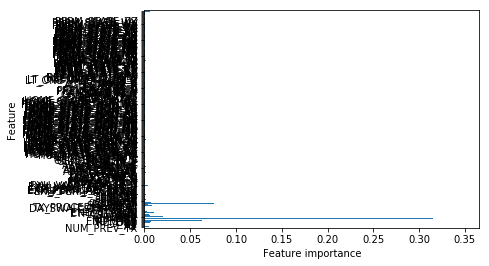

In [16]:
def plot_feature_importances_(model):
    n_features = X_test.shape[1]
    plt.barh(np.arange(n_features),model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features),df.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances_(model)

In [45]:
num_21 =  X[21,:].copy().reshape(1, -1)
num_21  = pd.DataFrame(num_21, columns = df[X_variables].columns)
num_21.iloc[0,:160]

NUM_PREV_TX             0.0
A1                     11.0
A2                     28.0
B1                      8.0
B2                     44.0
DR1                     3.0
DR2                     4.0
REM_CD                  4.0
END_STAT             4010.0
INIT_AGE               43.0
ethnicity               0.0
ethcat                  1.0
region                  4.0
RB1                     8.0
npkid                   0.0
AGE_DON                20.0
ETHCAT_DON              1.0
END_STAT_KI          4010.0
age                    43.0
GTIME_KI             1190.0
GSTATUS_KI              1.0
TX_PROCEDUR_TY_KI     102.0
pstatus                 1.0
ptime                1190.0
SHARE_TY                3.0
year                 1994.0
month                   4.0
gender_F                0.0
gender_M                1.0
abo_A                   0.0
                      ...  
HOME_STATE_DON_ZZ       0.0
ABO_MAT_1               0.0
ABO_MAT_1               1.0
ABO_MAT_                0.0
ABO_MAT_1           

### This is where the magic happens!

In [46]:
state_names = ['AK','AL','AR','AS','AZ','CA','CO','CT','DC','DE','FL','GA',
               'GU','HI','IA','ID','IL','IN','KS','KY','LA','MA','MD','ME',
               'MI','MN','MO','MP','MS','MT','NA','NC','ND','NE','NH','NJ',
               'NM','NV','NY','OH','OK','OR','PA','PR','RI','SC','SD','TN',
               'TX','UT','VA','VI','VT','WA','WI','WV','WY','ZZ']

### This is a for loop that takes the random sample from quintile 0 and predicts their waitlist time changing the state they live in each time for all states and territories. It puts this info into a data frame, wl_times_0 and then we can take summary stats on this dataframe. W

### When I increase the sample size to 100 or 1,000 I am not quite sure what summary stats to report on that right now, maybe the distribution of waitlist variances? See how

In [103]:
sampling_0 = random.sample(rand_people_0_wl, k=25)
sampling_0

[38699,
 208384,
 10461,
 180564,
 382456,
 85121,
 73835,
 177834,
 218562,
 182476,
 89151,
 86899,
 85287,
 202573,
 85237,
 51033,
 131145,
 83761,
 305751,
 96349,
 128046,
 85823,
 206779,
 102424,
 371399]

In [104]:
wl_times_0 = pd.DataFrame()
wl_times_0['state']= state_names


for j in sampling_0:
    List = []
    for i in range(58):
        A = np.zeros((58,), dtype=int)
        A[i]=1
            
        num_10000 = np.concatenate((X[j,:160].copy(),A), axis = None).reshape(1,-1)
        List.append(model.predict(num_10000))
        #print(model.predict(num_10000))
        
    List = np.asarray(List)  
    wl_times_0[j] = List


wl_times_0.describe()
wl_times_0.to_excel(r'C:\Users\jordan79\Desktop\wl_0.xlsx')
results = pd.DataFrame(wl_times_0.describe())
results.to_excel(r'C:\Users\jordan79\Desktop\wl_0_results.xlsx')

In [146]:
results = pd.DataFrame(wl_times_0.describe())
results

,38699,208384,10461,180564,382456,85121,73835,177834,218562,182476,...,51033,131145,83761,305751,96349,128046,85823,206779,102424,371399
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,...,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,164.110837,99.519704,104.288177,1495.221675,385.357143,109.472906,370.014778,991.219212,923.921182,472.081281,...,242.674877,194.992611,274.990148,59.992611,342.554187,102.226601,170.876847,321.571429,201.379310,64.815271
std,44.222147,64.802974,129.072550,6.521449,29.665533,15.376390,82.795875,6.372336,119.337280,7.411254,...,19.222942,16.915671,21.001899,11.794621,62.067114,109.887760,45.933781,10.188696,23.508628,11.571785
min,70.285714,68.857143,44.571429,1471.571429,332.428571,97.285714,221.714286,963.000000,753.571429,419.142857,...,234.000000,160.857143,240.142857,42.857143,244.000000,68.142857,146.000000,288.857143,126.857143,34.285714
25%,148.857143,78.000000,44.571429,1494.428571,382.142857,106.285714,351.714286,992.571429,885.000000,472.714286,...,238.857143,189.285714,271.571429,57.428571,323.857143,68.142857,158.428571,321.571429,198.000000,62.142857
50%,148.857143,78.000000,44.571429,1494.428571,382.142857,106.285714,351.714286,992.571429,885.000000,472.714286,...,238.857143,189.285714,271.571429,57.428571,323.857143,68.142857,158.428571,321.571429,198.000000,62.142857
75%,148.857143,80.892857,114.500000,1494.428571,382.142857,106.285714,351.714286,992.571429,885.000000,472.714286,...,238.857143,189.285714,271.571429,57.428571,329.678571,68.142857,158.428571,321.571429,198.000000,62.142857
max,313.571429,476.285714,821.571429,1529.714286,570.000000,213.142857,770.714286,1006.285714,1432.428571,489.571429,...,369.571429,262.428571,404.428571,134.714286,654.285714,584.285714,384.000000,382.142857,288.428571,120.571429


In [145]:
for i in range(8):
    print(results.iloc[i,:].median())

58.0
242.67487684729076
23.508628299595927
221.71428571428572
238.85714285714286
238.85714285714286
238.85714285714286
476.2857142857143


In [147]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Text(0.5, 1.0, 'Distribution of Monthly Returns: 1926-2018')

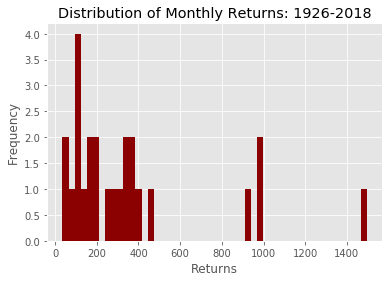

In [154]:
ax = results.iloc[1,:].plot.hist(bins = 50,color='darkred')
ax.set_xlabel('Returns')
ax.set_title('Distribution of Monthly Returns: 1926-2018')
#ax.set_xlim(-25,25)

(array([0.00205497, 0.00342495, 0.00273996, 0.00068499, 0.00136998,
        0.00273996, 0.00068499, 0.00068499, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00068499, 0.00136998, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00068499]),
 array([  35.34729064,   93.74226601,  152.13724138,  210.53221675,
         268.92719212,  327.32216749,  385.71714286,  444.11211823,
         502.5070936 ,  560.90206897,  619.29704433,  677.6920197 ,
         736.08699507,  794.48197044,  852.87694581,  911.27192118,
         969.66689655, 1028.06187192, 1086.45684729, 1144.85182266,
        1203.24679803, 1261.6417734 , 1320.03674877, 1378.43172414,
        1436.82669951, 1495.22167488]),
 <a list of 25 Patch objects>)

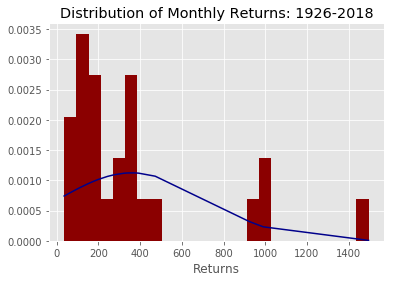

In [164]:
from scipy.stats import norm
x = sorted(results.iloc[1,:])
fit = norm.pdf(x, np.mean(x), np.std(x))

fig, ax = plt.subplots()

ax.set_xlabel('Returns')
ax.set_title('Distribution of Monthly Returns: 1926-2018')
#ax.set_xlim(-25,25)

plt.plot(x,fit,color='darkblue')
plt.hist(x,density=True,bins=25,color='darkred')

In [105]:
wl_times_1 = pd.DataFrame()
wl_times_1['state']= state_names


for j in sampling_1:
    List = []
    for i in range(58):
        A = np.zeros((58,), dtype=int)
        A[i]=1
            
        num_10000 = np.concatenate((X[j,:160].copy(),A), axis = None).reshape(1,-1)
        List.append(model.predict(num_10000))
        #print(model.predict(num_10000))
        
    List = np.asarray(List)  
    wl_times_1[j] = List


wl_times_1.describe()
wl_times_1.to_excel(r'C:\Users\jordan79\Desktop\wl_1.xlsx')
results = pd.DataFrame(wl_times_1.describe())
results.to_excel(r'C:\Users\jordan79\Desktop\wl_1_results.xlsx')

In [106]:
wl_times_2 = pd.DataFrame()
wl_times_2['state']= state_names


for j in sampling_2:
    List = []
    for i in range(58):
        A = np.zeros((58,), dtype=int)
        A[i]=1
            
        num_10000 = np.concatenate((X[j,:160].copy(),A), axis = None).reshape(1,-1)
        List.append(model.predict(num_10000))
        #print(model.predict(num_10000))
        
    List = np.asarray(List)  
    wl_times_2[j] = List


wl_times_2.describe()
wl_times_2.to_excel(r'C:\Users\jordan79\Desktop\wl_2.xlsx')
results = pd.DataFrame(wl_times_2.describe())
results.to_excel(r'C:\Users\jordan79\Desktop\wl_2_results.xlsx')

In [107]:
wl_times_3 = pd.DataFrame()
wl_times_3['state']= state_names


for j in sampling_3:
    List = []
    for i in range(58):
        A = np.zeros((58,), dtype=int)
        A[i]=1
            
        num_10000 = np.concatenate((X[j,:160].copy(),A), axis = None).reshape(1,-1)
        List.append(model.predict(num_10000))
        #print(model.predict(num_10000))
        
    List = np.asarray(List)  
    wl_times_3[j] = List


wl_times_3.describe()
wl_times_3.to_excel(r'C:\Users\jordan79\Desktop\wl_3.xlsx')
results = pd.DataFrame(wl_times_3.describe())
results.to_excel(r'C:\Users\jordan79\Desktop\wl_3_results.xlsx')

In [108]:
wl_times_4 = pd.DataFrame()
wl_times_4['state']= state_names


for j in sampling_4:
    List = []
    for i in range(58):
        A = np.zeros((58,), dtype=int)
        A[i]=1
            
        num_10000 = np.concatenate((X[j,:160].copy(),A), axis = None).reshape(1,-1)
        List.append(model.predict(num_10000))
        #print(model.predict(num_10000))
        
    List = np.asarray(List)  
    wl_times_4[j] = List


wl_times_4.describe()
wl_times_4.to_excel(r'C:\Users\jordan79\Desktop\wl_4.xlsx')
results = pd.DataFrame(wl_times_4.describe())
results.to_excel(r'C:\Users\jordan79\Desktop\wl_4_results.xlsx')

### Now we repeat this process for the "average people"
### They are at the end of the data frame, they are ordered short, medium, long. 

In [111]:


wl_times_ave_peeps = pd.DataFrame()
wl_times_ave_peeps['state']= state_names
ave_peep_id = [401748,401749,401750]

for j in ave_peep_id:
    List = []
    for i in range(58):
        A = np.zeros((58,), dtype=int)
        A[i]=1
            
        num_10000 = np.concatenate((X[j,:160].copy(),A), axis = None).reshape(1,-1)
        List.append(model.predict(num_10000))
        #print(model.predict(num_10000))
        
    List = np.asarray(List)  
    wl_times_ave_peeps[j] = List


wl_times_ave_peeps.describe()

,401748,401749,401750
count,58.000000,58.000000,58.000000
mean,304.192118,404.711823,1556.384236
std,67.902051,11.599273,22.057540
min,196.000000,378.857143,1537.714286
25%,287.857143,402.714286,1552.285714
50%,287.857143,402.714286,1552.285714
75%,287.857143,402.714286,1552.285714
max,685.285714,462.142857,1700.428571


In [110]:
wl_times_ave_peeps.to_excel(r'C:\Users\jordan79\Desktop\wl_ave_peeps.xlsx')
results = pd.DataFrame(wl_times_ave_peeps.describe())
results.to_excel(r'C:\Users\jordan79\Desktop\wl_ave_peeps_results.xlsx')


###  Now we want to test the National Model or the model that is trained without any states in it. 

In [113]:
df_1.tail()

,NUM_PREV_TX,A1,A2,B1,B2,DR1,DR2,gender,abo,PERM_STATE,...,PX_STAT,SHARE_TY,pstatus,ptime,AGE_GROUP,malig,LT_ONE_WEEK_DON,RECOV_OUT_US,year,month
401746,0,36,68,53,57,11,13,M,O,IL,...,A,3,0,3.0,A,N,N,,2018,12
401747,1,2,2,55,57,4,7,F,O,IN,...,A,3,0,19.0,P,N,N,,2018,10
401748,0,2,24,27,49,4,11,M,A,CA,...,A,3,0,2031.0,A,N,N,N,2006,7
401749,0,2,24,35,50,7,11,M,O,CA,...,A,3,0,2177.0,A,N,N,N,2006,7
401750,0,2,28,35,51,7,12,M,O,CA,...,A,3,0,1677.0,A,N,N,N,2010,7


In [114]:
df_1 = df_1.drop('PERM_STATE', axis=1)

dummy_columns = ['gender', 'abo', 'EXH_PERIT_ACCESS', 'EXH_VASC_ACCESS', 'PREV_TX', 'PREV_KI_TX',
                 'MALIG_TRR', 'txkid', 'ABO_DON','DON_TY', 'GENDER_DON',
                 'HOME_STATE_DON', 'ABO_MAT', 'GRF_STAT_KI', 'DWFG_KI', 'PREV_TX_ANY', 'PX_STAT',
                 'SHARE_TY', 'AGE_GROUP', 'malig', 'LT_ONE_WEEK_DON', 'RECOV_OUT_US', 'year', 'month']
funky_columns = ['TX_PROCEDUR_TY_KI']
df_1_non_dummy = df_1.drop(dummy_columns, axis=1)
df_1_dummified = pd.get_dummies(df_1[dummy_columns])
df_1 = df_1_non_dummy.merge(df_1_dummified, left_index=True, right_index=True)

In [115]:
df_1.head()

,NUM_PREV_TX,A1,A2,B1,B2,DR1,DR2,REM_CD,END_STAT,INIT_AGE,...,AGE_GROUP_A,AGE_GROUP_P,malig_N,malig_U,malig_Y,LT_ONE_WEEK_DON_N,LT_ONE_WEEK_DON_Y,RECOV_OUT_US_,RECOV_OUT_US_N,RECOV_OUT_US_Y
0,0,1,26,38,44,1,4,4,4010,38.0,...,1,0,0,1,0,1,0,0,1,0
1,1,2,23,44,62,7,11,4,4010,43.0,...,1,0,0,1,0,1,0,0,1,0
2,0,3,25,7,27,1,13,15,4010,42.0,...,1,0,0,1,0,1,0,0,1,0
3,0,2,68,35,39,4,0,4,4010,9.0,...,0,1,0,1,0,1,0,0,1,0
4,0,1,2,62,27,3,4,4,4010,25.0,...,1,0,0,1,0,1,0,0,1,0


## This is the national model trained without any state dummies

In [116]:
y_variable = 'DAYSWAIT_CHRON_KI'
X_variables = list(df_1.columns[df_1.columns != y_variable])
X = df_1[X_variables].to_numpy()
y = df_1[y_variable].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y)

forest = RandomForestRegressor(n_estimators=7)
model_national = forest.fit(X_train, y_train)

In [117]:
model_national.score(X_test,y_test)

0.8354873619223938

In [ ]:
num_21 =  X[21,:].copy().reshape(1, -1)
num_21  = pd.DataFrame(num_21, columns = df[X_variables].columns)
num_21.iloc[0,:160]

### People in the Bottom Quintile of WL_time, predicted values in the national model

In [124]:
List = []
wl_times_national_0 = []
for j in sampling_0:
   
    obs = (X[j,:].copy().reshape(1,-1))
    List.append(model_national.predict(obs))
#List = np.asarray(List) 
wl_times_national_0=List
wl_times_national_0 = pd.DataFrame(wl_times_national_0)
#wl_times.set_index(list(sampling_0))
wl_times_national_0.describe()
wl_times_national_0.to_excel(r'C:\Users\jordan79\Desktop\wl_n_0.xlsx')
results = pd.DataFrame(wl_times_national_0.describe())
results.to_excel(r'C:\Users\jordan79\Desktop\wl_n_0_results.xlsx')

In [161]:
wl_times_national_0.iloc[:,0]

0      247.142857
1       77.428571
2      340.285714
3     1451.000000
4      288.714286
5       71.285714
6      363.000000
7      976.142857
8     1009.428571
9      461.142857
10     107.714286
11     432.857143
12     424.285714
13     679.285714
14     210.571429
15     251.571429
16     125.000000
17     272.714286
18      28.142857
19     749.428571
20     276.000000
21     107.571429
22     578.571429
23     281.571429
24      39.714286
Name: 0, dtype: float64

(array([0.00281124, 0.00210843, 0.        , 0.00210843, 0.00281124,
        0.00140562, 0.00070281, 0.00140562, 0.        , 0.00070281,
        0.        , 0.00070281, 0.00070281, 0.        , 0.        ,
        0.        , 0.00070281, 0.00070281, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00070281]),
 array([  28.14285714,   85.05714286,  141.97142857,  198.88571429,
         255.8       ,  312.71428571,  369.62857143,  426.54285714,
         483.45714286,  540.37142857,  597.28571429,  654.2       ,
         711.11428571,  768.02857143,  824.94285714,  881.85714286,
         938.77142857,  995.68571429, 1052.6       , 1109.51428571,
        1166.42857143, 1223.34285714, 1280.25714286, 1337.17142857,
        1394.08571429, 1451.        ]),
 <a list of 25 Patch objects>)

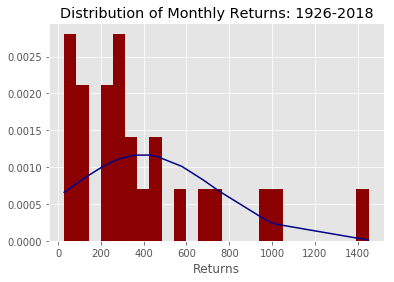

In [163]:
from scipy.stats import norm
x = sorted(wl_times_national_0.iloc[:,0])
fit = norm.pdf(x, np.mean(x), np.std(x))

fig, ax = plt.subplots()

ax.set_xlabel('Returns')
ax.set_title('Distribution of Monthly Returns: 1926-2018')
#ax.set_xlim(-25,25)

plt.plot(x,fit,color='darkblue')
plt.hist(x,density=True,bins=25,color='darkred')

In [125]:
List = []
wl_times_national_1 = []
for j in sampling_1:
   
    obs = (X[j,:].copy().reshape(1,-1))
    List.append(model_national.predict(obs))
#List = np.asarray(List) 
wl_times_national_1=List
wl_times_national_1 = pd.DataFrame(wl_times_national_1)
#wl_times.set_index(list(sampling_0))
wl_times_national_1.describe()
wl_times_national_1.to_excel(r'C:\Users\jordan79\Desktop\wl_n_1.xlsx')
results = pd.DataFrame(wl_times_national_1.describe())
results.to_excel(r'C:\Users\jordan79\Desktop\wl_n_1_results.xlsx')

In [126]:
List = []
wl_times_national_2 = []
for j in sampling_2:
   
    obs = (X[j,:].copy().reshape(1,-1))
    List.append(model_national.predict(obs))
#List = np.asarray(List) 
wl_times_national_2=List
wl_times_national_2 = pd.DataFrame(wl_times_national_2)
#wl_times.set_index(list(sampling_2))
wl_times_national_2.describe()
wl_times_national_2.to_excel(r'C:\Users\jordan79\Desktop\wl_n_2.xlsx')
results = pd.DataFrame(wl_times_national_2.describe())
results.to_excel(r'C:\Users\jordan79\Desktop\wl_n_2_results.xlsx')

In [127]:
List = []
wl_times_national_3 = []
for j in sampling_3:
   
    obs = (X[j,:].copy().reshape(1,-1))
    List.append(model_national.predict(obs))
#List = np.asarray(List) 
wl_times_national_3=List
wl_times_national_3 = pd.DataFrame(wl_times_national_3)
#wl_times.set_index(list(sampling_3))
wl_times_national_3.describe()
wl_times_national_3.to_excel(r'C:\Users\jordan79\Desktop\wl_n_3.xlsx')
results = pd.DataFrame(wl_times_national_3.describe())
results.to_excel(r'C:\Users\jordan79\Desktop\wl_n_3_results.xlsx')

In [128]:
List = []
wl_times_national_4 = []
for j in sampling_4:
   
    obs = (X[j,:].copy().reshape(1,-1))
    List.append(model_national.predict(obs))
#List = np.asarray(List) 
wl_times_national_4=List
wl_times_national_4 = pd.DataFrame(wl_times_national_4)
#wl_times.set_index(list(sampling_4))
wl_times_national_4.describe()
wl_times_national_4.to_excel(r'C:\Users\jordan79\Desktop\wl_n_4.xlsx')
results = pd.DataFrame(wl_times_national_4.describe())
results.to_excel(r'C:\Users\jordan79\Desktop\wl_n_4_results.xlsx')

### Now the average people in the National Model

In [133]:
List = []
wl_ave_peeps_national = []
ave_peep_id = [401748,401749,401750]

for j in ave_peep_id:
   
    obs = (X[j,:].copy().reshape(1,-1))
    List.append(model_national.predict(obs))
#List = np.asarray(List) 
wl_ave_peeps_national=List
wl_ave_peeps_national = pd.DataFrame(wl_ave_peeps_national)
#wl_times.set_index(list(sampling_4))
wl_ave_peeps_national.describe()
wl_ave_peeps_national.to_excel(r'C:\Users\jordan79\Desktop\wl_ave_national.xlsx')
results = pd.DataFrame(wl_ave_peeps_national.describe())
results.to_excel(r'C:\Users\jordan79\Desktop\wl_ave_national_results.xlsx')

In [166]:
wl_ave_peeps_national

,0
0,330.428571
1,360.714286
2,1647.285714


### Interesting....
### So for the average person with short wl_time the national model is worse, for the medium wl_time person it is better, and for the long wl_time person it is worse. 

### I guess this kind of makes sense. The people we would think would benefit the most from a no state borders are the people who match with the most people. 